#Data Modeling

## Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


Mounted at /content/drive


## Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
import os
from sklearn.metrics import classification_report
import joblib



## Notebook Setup

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/generic-mix-topics-nlp'
DATA_PATH = os.path.join(ROOT_PATH, 'Data')
MODELS_PATH = os.path.join(ROOT_PATH, 'Models')

os.makedirs(MODELS_PATH, exist_ok=True)


##Data Loading

In [ ]:

# Caricamento del dataset pulito
df_cleaned = pd.read_parquet(os.path.join(DATA_PATH, 'cleaned_dataset_no_outliers.parquet'))

In [ ]:
len(df_cleaned)

180003

## Train, Validation, Test Split

In [ ]:

# Definire le feature e le label
X = df_cleaned['preprocessed_text']
y = df_cleaned.drop(columns=['preprocessed_text'])

# Divisione in training e validation set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 3: Dividere il set temporaneo in validation e test set (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
len(X_train), len(X_val), len(X_test)

(108001, 36001, 36001)

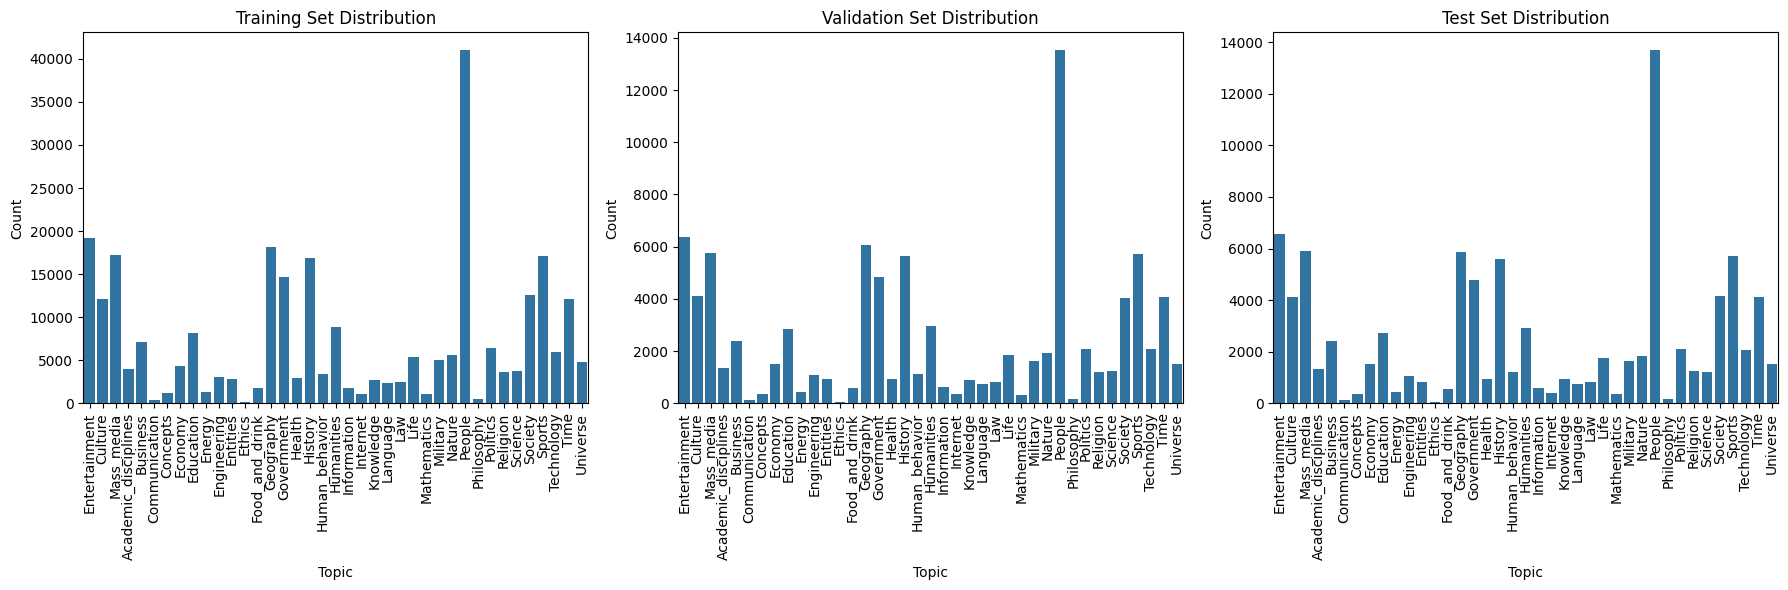

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolare la distribuzione delle etichette per i tre dataset
train_distribution = y_train.sum()
val_distribution = y_val.sum()
test_distribution = y_test.sum()

# Impostare la figura con tre subplot in fila
plt.figure(figsize=(18, 6))

# Plot per il Training Set
plt.subplot(1, 3, 1)
sns.barplot(x=train_distribution.index, y=train_distribution.values)
plt.title('Training Set Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Plot per il Validation Set
plt.subplot(1, 3, 2)
sns.barplot(x=val_distribution.index, y=val_distribution.values)
plt.title('Validation Set Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Plot per il Test Set
plt.subplot(1, 3, 3)
sns.barplot(x=test_distribution.index, y=test_distribution.values)
plt.title('Test Set Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Mostrare il plot
plt.tight_layout()
plt.show()


In [ ]:
# Convertire le Series in DataFrame prima di salvarle
X_train_df = X_train.to_frame()
y_train_df = y_train

X_val_df = X_val.to_frame()
y_val_df = y_val

X_test_df = X_test.to_frame()
y_test_df = y_test

In [ ]:


# Salvare i DataFrame in file Parquet
X_train_df.to_parquet(os.path.join(DATA_PATH, 'X_train.parquet'), index=False)
y_train_df.to_parquet(os.path.join(DATA_PATH, 'y_train.parquet'), index=False)

X_val_df.to_parquet(os.path.join(DATA_PATH, 'X_val.parquet'), index=False)
y_val_df.to_parquet(os.path.join(DATA_PATH, 'y_val.parquet'), index=False)

X_test_df.to_parquet(os.path.join(DATA_PATH, 'X_test.parquet'), index=False)
y_test_df.to_parquet(os.path.join(DATA_PATH, 'y_test.parquet'), index=False)


## Downsampling for Train set

In [ ]:
from sklearn.utils import resample

# Uniamo X_train e y_train per facilitare il downsampling
train_data = pd.concat([X_train, y_train], axis=1)

# Downsample delle classi maggioritarie al livello della classe minoritaria
min_count = y_train.sum(axis=0).min()  # Trova la classe meno rappresentata

# Lista per memorizzare i downsampled dataframe
downsampled_dfs = []

for col in y_train.columns:
    class_data = train_data[train_data[col] == 1]
    downsampled_data = resample(class_data,
                                replace=False,  # Non fare upsampling
                                n_samples=min_count,  # Numero di campioni uguali alla classe meno rappresentata
                                random_state=42)
    downsampled_dfs.append(downsampled_data)

# Concatenare tutti i dataframe downsampled
downsampled_train_data = pd.concat(downsampled_dfs)

# Dividere di nuovo in X_train e y_train
X_train_downsampled = downsampled_train_data['preprocessed_text']
y_train_downsampled = downsampled_train_data.drop(columns=['preprocessed_text'])


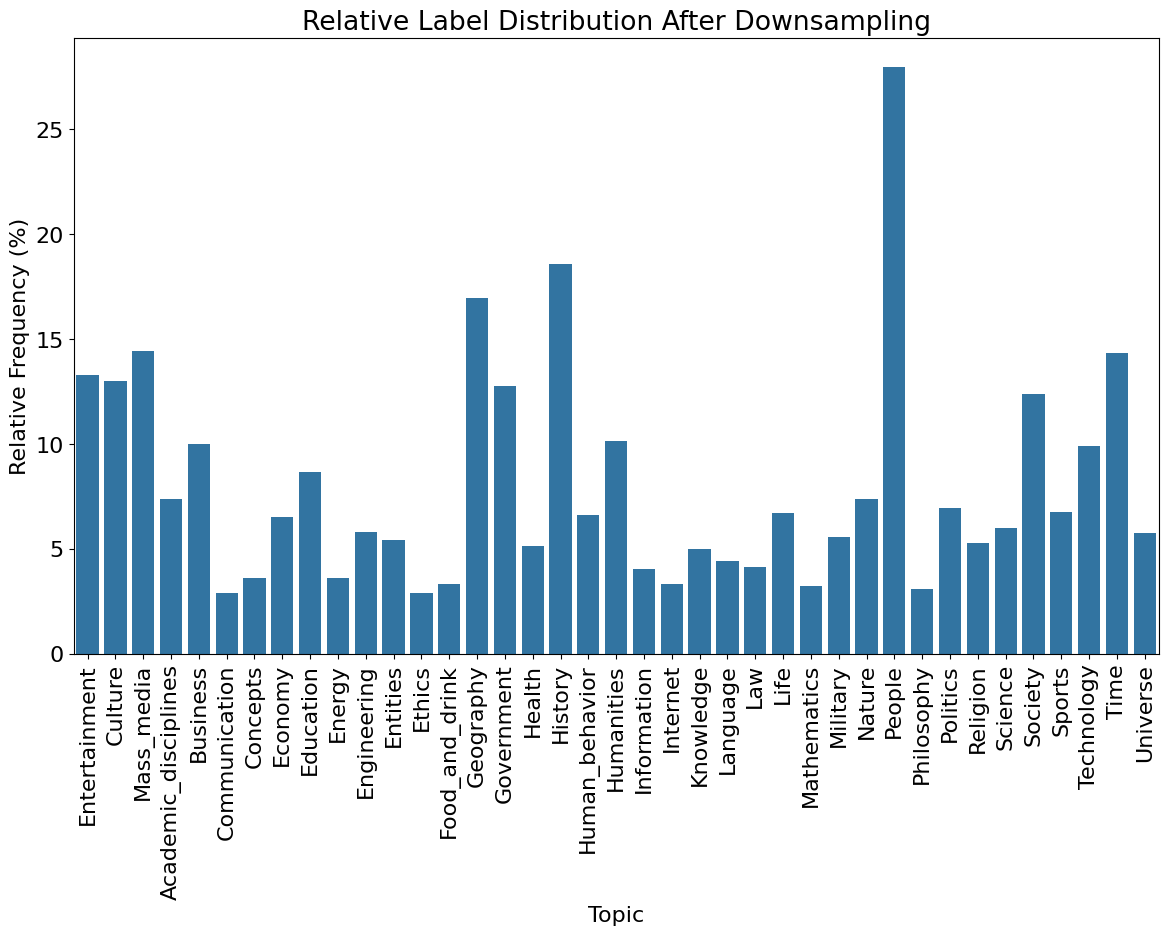

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolare la distribuzione delle etichette nel dataset downsampled
downsampled_distribution = y_train_downsampled.sum()

# Calcolare la frequenza relativa rispetto al totale delle righe
total_rows = len(y_train_downsampled)
relative_distribution = (downsampled_distribution / total_rows) * 100
# Imposta la dimensione del font
font_size = 16
plt.rcParams.update({'font.size': font_size})
# Creare il plot della distribuzione delle etichette con frequenza relativa
plt.figure(figsize=(14, 8))
sns.barplot(x=relative_distribution.index, y=relative_distribution.values)
plt.title('Relative Label Distribution After Downsampling')
plt.xlabel('Topic')
plt.ylabel('Relative Frequency (%)')
plt.xticks(rotation=90)  # Ruota le etichette per una migliore leggibilità
plt.show()


In [ ]:
X_train_downsampled.shape, y_train_downsampled.shape

((8346,), (8346, 39))

## Training ML Light Models

### Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import joblib

# Creare una pipeline con TfidfVectorizer e LogisticRegression
pipeline_logreg = Pipeline([
       ('tfidf', TfidfVectorizer(max_features = 30000, ngram_range=(1, 2), min_df = 0.001, max_df = 0.8)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', verbose=4)))
])

# Allenare il modello Logistic Regression
pipeline_logreg.fit(X_train, y_train)

# Prevedere sul training set con Logistic Regression
y_pred_logreg_train = pipeline_logreg.predict(X_train)

# Valutazione del modello Logistic Regression sul training set
print("Logistic Regression Train Results")
print(classification_report(y_train, y_pred_logreg_train, target_names=y_train.columns))

# Prevedere sul validation set con Logistic Regression
y_pred_logreg_val = pipeline_logreg.predict(X_val)

# Valutazione del modello Logistic Regression sul validation set
print("Logistic Regression Validation Results")
print(classification_report(y_val, y_pred_logreg_val, target_names=y_val.columns))

# Salvare il modello addestrato
model_filename = os.path.join(MODELS_PATH, 'logistic_regression_pipeline_v1.pkl')
joblib.dump(pipeline_logreg, model_filename)

print(f"Modello salvato in {model_filename}")


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Logistic Regression Train Results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

       Entertainment       0.86      0.79      0.82     19203
             Culture       0.78      0.35      0.48     12130
          Mass_media       0.82      0.71      0.76     17236
Academic_disciplines       0.84      0.17      0.28      3972
            Business       0.77      0.42      0.54      7174
       Communication       0.71      0.03      0.05       363
            Concepts       0.92      0.22      0.36      1208
             Economy       0.86      0.49      0.63      4334
           Education       0.82      0.53      0.64      8183
              Energy       0.87      0.45      0.59      1313
         Engineering       0.77      0.25      0.38      3118
            Entities       0.84      0.08      0.14      2827
              Ethics       0.80      0.02      0.04       214
      Food_and_drink       0.93      0.45      0.61      1744
           Geography       0.87      0.65      0.74     18111
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

       Entertainment       0.84      0.75      0.79      6389
             Culture       0.69      0.29      0.41      4103
          Mass_media       0.77      0.66      0.71      5756
Academic_disciplines       0.73      0.12      0.21      1376
            Business       0.67      0.36      0.47      2396
       Communication       0.60      0.02      0.04       137
            Concepts       0.90      0.20      0.33       377
             Economy       0.81      0.46      0.58      1527
           Education       0.76      0.47      0.58      2857
              Energy       0.83      0.41      0.54       437
         Engineering       0.70      0.21      0.32      1109
            Entities       0.70      0.04      0.08       919
              Ethics       1.00      0.08      0.15        51
      Food_and_drink       0.89      0.39      0.54       599
           Geography       0.82      0.60      0.69      6049
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-11-071cdcb9ab3e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='class', y='f1_score', data=df_scores, palette="Blues")
<ipython-input-11-071cdcb9ab3e>:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


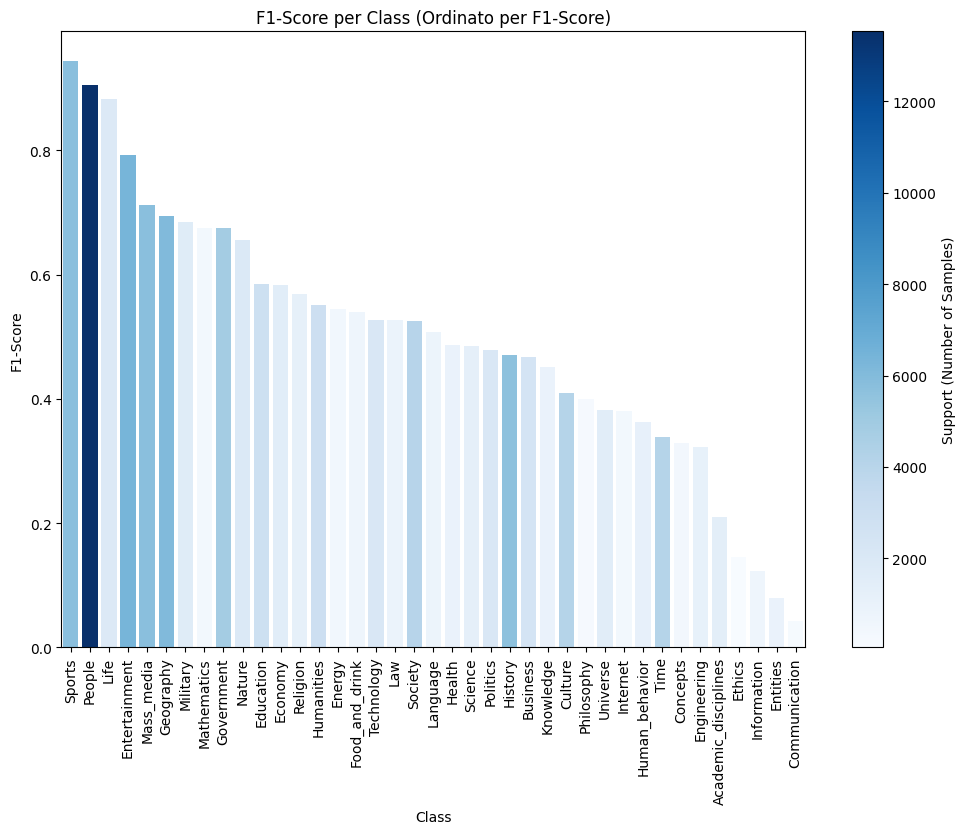

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Generare il classification report
report = classification_report(y_val, y_pred_logreg_val, target_names=y.columns, output_dict=True)

# Estrai F1-score e support (numerosità) per ogni classe
f1_scores = [report[label]['f1-score'] for label in y.columns]
supports = [report[label]['support'] for label in y.columns]

# Converti in array numpy per facilitare i calcoli
f1_scores = np.array(f1_scores)
supports = np.array(supports)

# Creare un DataFrame per facilitare l'ordinamento
df_scores = pd.DataFrame({
    'class': y.columns,
    'f1_score': f1_scores,
    'support': supports
})

# Ordinare il DataFrame in base a F1-score in ordine decrescente
df_scores = df_scores.sort_values(by='f1_score', ascending=False)

# Normalizzare i valori di supporto per ottenere colori tra 0 e 1
colors = df_scores['support'] / df_scores['support'].max()

# Creare il plot
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='class', y='f1_score', data=df_scores, palette="Blues")

# Imposta l'intensità del colore in base al supporto
for i, patch in enumerate(bars.patches):
    color_intensity = plt.cm.Blues(colors.iloc[i])
    patch.set_facecolor(color_intensity)

# Aggiungere una barra di colore (color bar) per la leggenda dell'intensità
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=df_scores['support'].min(), vmax=df_scores['support'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Support (Number of Samples)')

plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score per Class (Ordinato per F1-Score)')
plt.show()


### Naive Bayes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import joblib

# Creare una pipeline con TfidfVectorizer e Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])

# Allenare il modello Naive Bayes
pipeline_nb.fit(X_train, y_train)

# Prevedere sul training set con Naive Bayes
y_pred_nb_train = pipeline_nb.predict(X_train)

# Valutazione del modello Naive Bayes sul training set
print("Naive Bayes Train Results")
print(classification_report(y_train, y_pred_nb_train, target_names=y_train.columns))

# Prevedere sul validation set con Naive Bayes
y_pred_nb_val = pipeline_nb.predict(X_val)

# Valutazione del modello Naive Bayes sul validation set
print("Naive Bayes Validation Results")
print(classification_report(y_val, y_pred_nb_val, target_names=y_val.columns))

# Salvare il modello addestrato
nb_model_filename = os.path.join(MODELS_PATH, 'naive_bayes_pipeline.pkl')
joblib.dump(pipeline_nb, nb_model_filename)

print(f"Modello Naive Bayes salvato in {nb_model_filename}")


Naive Bayes Train Results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

       Entertainment       0.96      0.07      0.13     19203
             Culture       0.80      0.00      0.00     12130
          Mass_media       0.99      0.02      0.03     17236
Academic_disciplines       0.00      0.00      0.00      3972
            Business       0.00      0.00      0.00      7174
       Communication       0.00      0.00      0.00       363
            Concepts       0.00      0.00      0.00      1208
             Economy       0.33      0.00      0.00      4334
           Education       0.00      0.00      0.00      8183
              Energy       0.00      0.00      0.00      1313
         Engineering       0.00      0.00      0.00      3118
            Entities       0.00      0.00      0.00      2827
              Ethics       0.00      0.00      0.00       214
      Food_and_drink       0.00      0.00      0.00      1744
           Geography       0.98      0.19      0.32     18111
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Modello Naive Bayes salvato in /content/drive/MyDrive/generic-mix-topics-nlp/Models/naive_bayes_pipeline.pkl


### Support Vector Machine

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import joblib

# Creare una pipeline con TfidfVectorizer e LinearSVC
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 30000, ngram_range=(1, 2), min_df = 0.001, max_df = 0.8)),
    ('clf', OneVsRestClassifier(LinearSVC(dual='auto', verbose=4)))
])

# Allenare il modello LinearSVC
pipeline_svm.fit(X_train, y_train)

# Prevedere sul training set con LinearSVC
y_pred_svm_train = pipeline_svm.predict(X_train)

# Valutazione del modello LinearSVC sul training set
print("LinearSVC Train Results")
print(classification_report(y_train, y_pred_svm_train, target_names=y_train.columns))

# Prevedere sul validation set con LinearSVC
y_pred_svm_val = pipeline_svm.predict(X_val)

# Valutazione del modello LinearSVC sul validation set
print("LinearSVC Validation Results")
print(classification_report(y_val, y_pred_svm_val, target_names=y_val.columns))

# Salvare il modello addestrato
svm_model_filename = os.path.join(MODELS_PATH, 'linear_svc_pipeline_v1.pkl')
joblib.dump(pipeline_svm, svm_model_filename)

print(f"Modello Linear SVC salvato in {svm_model_filename}")


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]LinearSVC Train Results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

       Entertainment       0.90      0.87      0.89     19203
             Culture       0.85      0.54      0.66     12130
          Mass_media       0.89      0.82      0.85     17236
Academic_disciplines       0.94      0.45      0.60      3972
            Business       0.89      0.65      0.75      7174
       Communication       0.99      0.68      0.81       363
            Concepts       0.97      0.65      0.78      1208
             Economy       0.93      0.70      0.80      4334
           Education       0.91      0.71      0.80      8183
              Energy       0.97      0.84      0.90      1313
         Engineering       0.92      0.57      0.70      3118
            Entities       0.96      0.33      0.49      2827
              Ethics       0.98      0.77      0.86       214
      Food_and_drink       0.97      0.80      0.88      1744
           Geography       0.90      0.75      0.82     18111
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

       Entertainment       0.82      0.77      0.79      6389
             Culture       0.61      0.36      0.45      4103
          Mass_media       0.75      0.69      0.72      5756
Academic_disciplines       0.59      0.22      0.32      1376
            Business       0.63      0.43      0.51      2396
       Communication       0.77      0.15      0.25       137
            Concepts       0.77      0.36      0.49       377
             Economy       0.76      0.51      0.61      1527
           Education       0.72      0.53      0.61      2857
              Energy       0.77      0.54      0.64       437
         Engineering       0.63      0.28      0.39      1109
            Entities       0.61      0.11      0.19       919
              Ethics       0.74      0.27      0.40        51
      Food_and_drink       0.82      0.55      0.66       599
           Geography       0.79      0.63      0.70      6049
       

##LLM

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch.nn as nn

# Supponiamo che X_train_downsampled e y_train_downsampled siano già definiti

# Tokenizzazione
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenizza il testo
X_train_tokens = tokenizer(list(X_train_downsampled), truncation=True, padding=True, max_length=512, return_tensors='pt')

# Converti le etichette in tensori PyTorch
labels = torch.tensor(y_train_downsampled.values).float()  # Converti le etichette in float per BCEWithLogitsLoss

# Crea un dataset personalizzato
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Crea il dataset di training
train_dataset = CustomDataset(X_train_tokens, labels)

# Crea un DataLoader per il training
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Configurazione del modello
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(y_train_downsampled.columns)
)
# Configurare il problema come classificazione multi-label
model.config.problem_type = "multi_label_classification"
# Aumenta il Dropout
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3

# Parametri di training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Riduci il numero di epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10
)


# Trainer di Hugging Face con dataloader personalizzato
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Utilizzare il dataset creato sopra
)

# Allenare il modello
trainer.train()

MODEL_SAVE_PATH = os.path.join(MODELS_PATH, 'distilbert_model')

# Assicurati che la cartella esista
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Salva il modello addestrato
model.save_pretrained(MODEL_SAVE_PATH)

# Salva il tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Modello e tokenizer salvati in {MODEL_SAVE_PATH}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.690500
20,0.685800
30,0.679100
40,0.667100
50,0.644400
60,0.609300
70,0.572700
80,0.536700
90,0.505300
100,0.474300


Modello e tokenizer salvati in /content/drive/MyDrive/generic-mix-topics-nlp/Models/distilbert_model


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Supponiamo che X_val e y_val siano già definiti

# Tokenizza il validation set
X_val_tokens = tokenizer(list(X_val), truncation=True, padding=True, max_length=512, return_tensors='pt')

# Non è necessario binarizzare di nuovo le etichette del validation set se sono già binarizzate
# Convertiamo direttamente y_val in tensori PyTorch
y_val_tensor = torch.tensor(y_val.values).float()

# Prevedere sul training set
train_predictions = trainer.predict(train_dataset)

# Ottieni le previsioni come logits dal training set
train_logits = train_predictions.predictions

# Converti i logits in probabilità con una funzione sigmoide (poiché DistilBERT ritorna logits)
train_pred_probs = torch.sigmoid(torch.tensor(train_logits)).numpy()

# Converti le probabilità in etichette binarie usando un threshold di 0.5
threshold = 0.5
y_train_pred = (train_pred_probs >= threshold).astype(int)

# Valutazione del modello sul training set
print("Training Results")
print(classification_report(y_train_downsampled, y_train_pred, target_names=y_train.columns))

# Tokenizza il validation set
X_val_tokens = tokenizer(list(X_val), truncation=True, padding=True, max_length=512, return_tensors='pt')

# Non è necessario binarizzare di nuovo le etichette del validation set se sono già binarizzate
# Convertiamo direttamente y_val in tensori PyTorch
y_val_tensor = torch.tensor(y_val.values).float()

# Crea un dataset per il validation set
val_dataset = CustomDataset(X_val_tokens, y_val_tensor)

# Prevedere sul validation set
val_predictions = trainer.predict(val_dataset)

# Ottieni le previsioni come logits dal validation set
val_logits = val_predictions.predictions

# Converti i logits in probabilità con una funzione sigmoide (poiché DistilBERT ritorna logits)
val_pred_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()

# Converti le probabilità in etichette binarie usando un threshold di 0.5
y_val_pred = (val_pred_probs >= threshold).astype(int)

# Valutazione del modello sul validation set
print("Validation Results")
print(classification_report(y_val, y_val_pred, target_names=y_val.columns))

Training Results
                      precision    recall  f1-score   support

       Entertainment       1.00      1.00      1.00      1107
             Culture       1.00      1.00      1.00      1086
          Mass_media       1.00      1.00      1.00      1202
Academic_disciplines       1.00      1.00      1.00       617
            Business       1.00      1.00      1.00       834
       Communication       1.00      1.00      1.00       242
            Concepts       1.00      1.00      1.00       302
             Economy       1.00      1.00      1.00       542
           Education       1.00      1.00      1.00       721
              Energy       1.00      1.00      1.00       301
         Engineering       1.00      1.00      1.00       483
            Entities       1.00      1.00      1.00       453
              Ethics       1.00      1.00      1.00       240
      Food_and_drink       1.00      0.99      1.00       277
           Geography       1.00      1.00      1.00 

In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Percorso dove hai salvato il modello e il tokenizer
MODEL_SAVE_PATH = os.path.join(MODELS_PATH, 'distilbert_model')

# Carica il tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_SAVE_PATH)

# Carica il modello
model = DistilBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

# Se stai usando un dispositivo GPU, sposta il modello sulla GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Modello e tokenizer caricati con successo.")


## Grouped Labels

In [ ]:
# Creare un nuovo DataFrame per le etichette raggruppate
y_train_grouped = pd.DataFrame()
y_val_grouped = pd.DataFrame()
y_test_grouped = pd.DataFrame()

# Raggruppamento delle etichette nel set di train
y_train_grouped['Culture_and_Society'] = y_train[['Culture', 'Society', 'Human_behavior', 'Religion', 'Philosophy', 'Ethics', 'People']].max(axis=1)
y_train_grouped['Academic_Disciplines'] = y_train[['Academic_disciplines', 'Humanities', 'History', 'Education', 'Language', 'Law', 'Concepts', 'Time']].max(axis=1)
y_train_grouped['STEM'] = y_train[['Mathematics', 'Technology', 'Science', 'Engineering', 'Internet', 'Information', 'Knowledge']].max(axis=1)
y_train_grouped['Economics'] = y_train[['Economy', 'Business', 'Communication']].max(axis=1)
y_train_grouped['Health'] = y_train[['Health', 'Food_and_drink', 'Life']].max(axis=1)
y_train_grouped['Entertainment'] = y_train[['Entertainment', 'Sports', 'Mass_media']].max(axis=1)
y_train_grouped['Environment'] = y_train[['Geography', 'Nature', 'Energy', 'Universe']].max(axis=1)
y_train_grouped['Government'] = y_train[['Government', 'Politics', 'Military', 'Entities']].max(axis=1)

# Raggruppamento delle etichette nel set di validation
y_val_grouped['Culture_and_Society'] = y_val[['Culture', 'Society', 'Human_behavior', 'Religion', 'Philosophy', 'Ethics', 'People']].max(axis=1)
y_val_grouped['Academic_Disciplines'] = y_val[['Academic_disciplines', 'Humanities', 'History', 'Education', 'Language', 'Law', 'Concepts', 'Time']].max(axis=1)
y_val_grouped['STEM'] = y_val[['Mathematics', 'Technology', 'Science', 'Engineering', 'Internet', 'Information', 'Knowledge']].max(axis=1)
y_val_grouped['Economics'] = y_val[['Economy', 'Business', 'Communication']].max(axis=1)
y_val_grouped['Health'] = y_val[['Health', 'Food_and_drink', 'Life']].max(axis=1)
y_val_grouped['Entertainment'] = y_val[['Entertainment', 'Sports', 'Mass_media']].max(axis=1)
y_val_grouped['Environment'] = y_val[['Geography', 'Nature', 'Energy', 'Universe']].max(axis=1)
y_val_grouped['Government'] = y_val[['Government', 'Politics', 'Military', 'Entities']].max(axis=1)

# Raggruppamento delle etichette nel set di test
y_test_grouped['Culture_and_Society'] = y_test[['Culture', 'Society', 'Human_behavior', 'Religion', 'Philosophy', 'Ethics', 'People']].max(axis=1)
y_test_grouped['Academic_Disciplines'] = y_test[['Academic_disciplines', 'Humanities', 'History', 'Education', 'Language', 'Law', 'Concepts', 'Time']].max(axis=1)
y_test_grouped['STEM'] = y_test[['Mathematics', 'Technology', 'Science', 'Engineering', 'Internet', 'Information', 'Knowledge']].max(axis=1)
y_test_grouped['Economics'] = y_test[['Economy', 'Business', 'Communication']].max(axis=1)
y_test_grouped['Health'] = y_test[['Health', 'Food_and_drink', 'Life']].max(axis=1)
y_test_grouped['Entertainment'] = y_test[['Entertainment', 'Sports', 'Mass_media']].max(axis=1)
y_test_grouped['Environment'] = y_test[['Geography', 'Nature', 'Energy', 'Universe']].max(axis=1)
y_test_grouped['Government'] = y_test[['Government', 'Politics', 'Military', 'Entities']].max(axis=1)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Creare una pipeline con TfidfVectorizer e LinearSVC
pipeline_svm_grouped = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 30000, ngram_range=(1, 2), min_df = 0.001, max_df = 0.8)),
    ('clf', OneVsRestClassifier(LinearSVC(dual='auto')))
])

# Allenare il modello SVM sul dataset raggruppato
pipeline_svm_grouped.fit(X_train, y_train_grouped)

# Prevedere sul training set con SVM per il dataset raggruppato
y_pred_svm_train_grouped = pipeline_svm_grouped.predict(X_train)

# Valutazione del modello SVM sul training set raggruppato
print("SVM Grouped Results on Training Set")
print(classification_report(y_train_grouped, y_pred_svm_train_grouped, target_names=y_train_grouped.columns))

# Prevedere sul validation set con SVM per il dataset raggruppato
y_pred_svm_grouped = pipeline_svm_grouped.predict(X_val)

# Valutazione del modello SVM sul validation set raggruppato
print("SVM Grouped Results on Validation Set")
print(classification_report(y_val_grouped, y_pred_svm_grouped, target_names=y_val_grouped.columns))


SVM Grouped Results on Training Set


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

 Culture_and_Society       0.92      0.90      0.91     63960
Academic_Disciplines       0.83      0.74      0.78     39243
                STEM       0.88      0.72      0.79     17031
           Economics       0.88      0.68      0.77     10963
              Health       0.96      0.84      0.89      9293
       Entertainment       0.95      0.94      0.94     39779
         Environment       0.90      0.78      0.83     23148
          Government       0.90      0.76      0.82     24037

           micro avg       0.90      0.82      0.86    227454
           macro avg       0.90      0.79      0.84    227454
        weighted avg       0.90      0.82      0.86    227454
         samples avg       0.90      0.85      0.85    227454

SVM Grouped Results on Validation Set
                      precision    recall  f1-score   support

 Culture_and_Society       0.86      0.84      0.85     21148
Academic_Disciplines       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm_grouped_model_filename = os.path.join(MODELS_PATH, 'svm_grouped_model.pkl')
joblib.dump(pipeline_svm_grouped, svm_grouped_model_filename)
print(f"Modello SVM Grouped salvato in {svm_grouped_model_filename}")

Modello SVM Grouped salvato in /content/drive/MyDrive/generic-mix-topics-nlp/Models/svm_grouped_model.pkl


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Creare una pipeline con TfidfVectorizer e LogisticRegression
pipeline_logreg_grouped = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 30000, ngram_range=(1, 2), min_df = 0.001, max_df = 0.8)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', verbose=4)))
])

# Allenare il modello Logistic Regression sul dataset raggruppato
pipeline_logreg_grouped.fit(X_train, y_train_grouped)

# Prevedere sul training set con Logistic Regression per il dataset raggruppato
y_pred_logreg_train_grouped = pipeline_logreg_grouped.predict(X_train)

# Valutazione del modello Logistic Regression sul training set raggruppato
print("Logistic Regression Grouped Results on Training Set")
print(classification_report(y_train_grouped, y_pred_logreg_train_grouped, target_names=y_train_grouped.columns))

# Prevedere sul validation set con Logistic Regression per il dataset raggruppato
y_pred_logreg_grouped = pipeline_logreg_grouped.predict(X_val)

# Valutazione del modello Logistic Regression sul validation set raggruppato
print("Logistic Regression Grouped Results on Validation Set")
print(classification_report(y_val_grouped, y_pred_logreg_grouped, target_names=y_val_grouped.columns))


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Logistic Regression Grouped Results on Training Set


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

 Culture_and_Society       0.89      0.87      0.88     63960
Academic_Disciplines       0.80      0.67      0.73     39243
                STEM       0.84      0.59      0.69     17031
           Economics       0.80      0.51      0.63     10963
              Health       0.94      0.71      0.81      9293
       Entertainment       0.93      0.91      0.92     39779
         Environment       0.87      0.69      0.77     23148
          Government       0.87      0.67      0.75     24037

           micro avg       0.87      0.76      0.81    227454
           macro avg       0.87      0.70      0.77    227454
        weighted avg       0.87      0.76      0.81    227454
         samples avg       0.87      0.79      0.80    227454

Logistic Regression Grouped Results on Validation Set
                      precision    recall  f1-score   support

 Culture_and_Society       0.86      0.85      0.86     21148
Academic_Dis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Salvare il modello Logistic Regression
logreg_grouped_model_filename = os.path.join(MODELS_PATH, 'logreg_grouped_model.pkl')
joblib.dump(pipeline_logreg_grouped, logreg_grouped_model_filename)
print(f"Modello Logistic Regression Grouped salvato in {logreg_grouped_model_filename}")

Modello Logistic Regression Grouped salvato in /content/drive/MyDrive/generic-mix-topics-nlp/Models/logreg_grouped_model.pkl
